In [1]:
%load_ext autoreload
%autoreload 2

import os
from travel import init_travel
init_travel()

# Load preds

In [2]:
import json

RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results/vqa_mistake_detection/ego4d/VQG2VQA_ego4d_debug_llava-1.5-7b-hf_spatial1.0_20240624115037/preds_heuristic_val.json"
preds = json.load(open(RESULTS_PATH, "r"))

# Visualize some outputs

In [29]:
import random

output_indices_to_visualize = random.sample(list(range(len(preds))), 1)

1 frames
{'answer_probs': {'0': 0.21199999749660492, '1': 0.7879999876022339},
 'example_id': 'b4707bc6-3579-4992-93ec-0eff21ba8922/8/hardneg',
 'expected_answer': 1,
 'frame': 'saved_results/vqa_mistake_detection/ego4d/VQG2VQA_ego4d_debug_llava-1.5-7b-hf_spatial1.0_20240624115037/VQA_cache_val_worker1of1/frames/frame_b4707bc6-3579-4992-93ec-0eff21ba8922-8-hardneg_de5aa942-450c-4e31-93ce-2df2dca685cd.jpg',
 'predicted_answer': 1,
 'procedure_id': 41008,
 'prompt': 'USER: <image>\nIs the cleanser container in the image? ASSISTANT: ',
 'question': 'Is the cleanser container on the table?',
 'task_name': 'ego4d'}
{'answer_probs': {'0': 0.4259999990463257, '1': 0.5740000009536743},
 'example_id': 'b4707bc6-3579-4992-93ec-0eff21ba8922/8/hardneg',
 'expected_answer': 0,
 'frame': 'saved_results/vqa_mistake_detection/ego4d/VQG2VQA_ego4d_debug_llava-1.5-7b-hf_spatial1.0_20240624115037/VQA_cache_val_worker1of1/frames/frame_b4707bc6-3579-4992-93ec-0eff21ba8922-8-hardneg_b72ff5a0-5dc5-4aad-9444-4

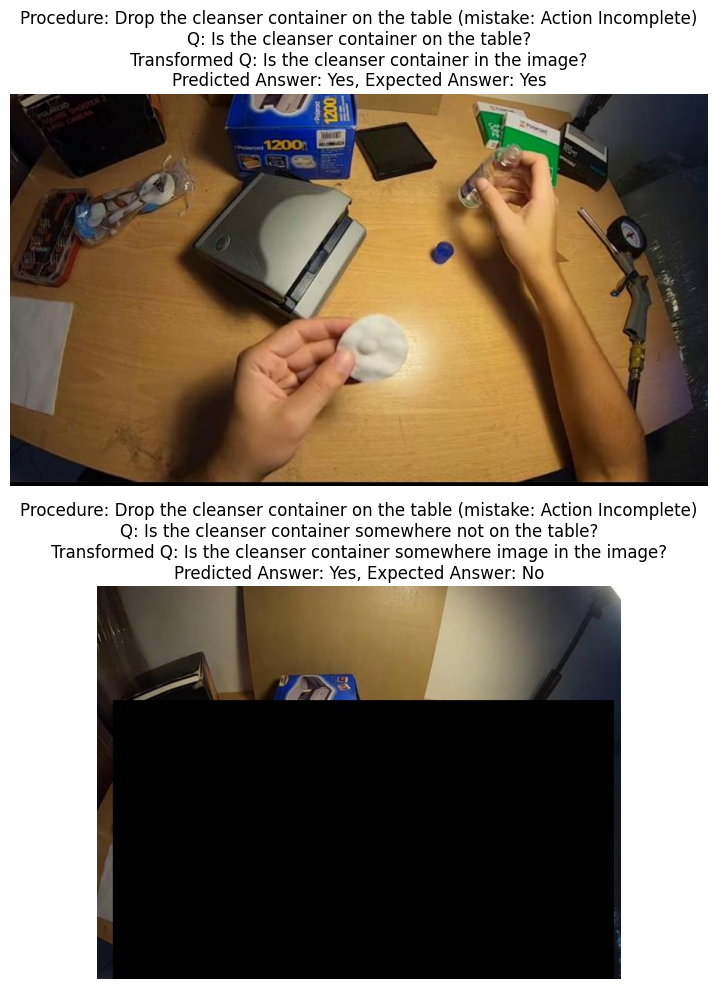

mistake_probs:
[[0.21199999749660492, 0.5740000009536743]]
nli_relevance_probs:
None
nli_mistake_probs:
None

MISTAKE CONFIDENCE AGGREGATION:
Mistake probs (input):
array([[0.212, 0.574]])
Mistake probs (after max):
array([0.574])
Mistake probs (after time-weighting)
[0.5740000009536743]
Mistake prob (final mean):
0.5740000009536743


In [30]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pprint import pprint

from travel.data.mistake_detection import MistakeDetectionExample, get_cutoff_time_by_proportion
from travel.model.vqa import VQAResponse
from travel.model.mistake_detection import aggregate_mistake_probs_over_frames
from travel.model.mistake_detection import DETECTION_FRAMES_PROPORTION

show_frames = True

keys = list(preds.keys())
for output_idx in output_indices_to_visualize:
    pred = preds[keys[output_idx]]

    procedure_description = pred['example']['procedure_description']
    mistake = pred["example"]["mistake"]

    # Extract the vqa list - just take the questions and answers for last frame
    print(f"{len(pred['vqa'])} frames")
    for frame_idx in range(len(pred['vqa'])):
        vqa_list = pred['vqa'][frame_idx]

        # Create a figure with a subplot for each entry
        num_entries = len(vqa_list)
        if show_frames:
            fig, axs = plt.subplots(num_entries, 1, figsize=(10, 5 * num_entries))

        for i, entry in enumerate(vqa_list):
            if 'frame' in entry and show_frames:
                ax = axs[i] if num_entries > 1 else axs
                img = mpimg.imread(entry['frame'])
                ax.imshow(img)
                ax.axis('off')

            question = entry['question']
            prompt = entry['prompt'].split("USER: <image>")[1].split("ASSISTANT:")[0].strip()
            predicted_answer = entry['predicted_answer']
            expected_answer = entry['expected_answer']

            title = f"Procedure: {procedure_description} ({'mistake' if mistake else 'success'}: {pred['example']['mistake_type']})\n"
            title += f"Q: {question}\n"
            title += f"Transformed Q: {prompt}\n"
            title += f"Predicted Answer: {VQAResponse(predicted_answer).name}, Expected Answer: {VQAResponse(expected_answer).name}"

            if 'frame' in entry and show_frames:
                ax.set_title(title)

            pprint(entry)

        if show_frames:
            plt.tight_layout()
            plt.show()

    # Print out probabilities
    for k in ["mistake_probs", "nli_relevance_probs", "nli_mistake_probs"]:
        print(k + ":")
        pprint(pred['mistake_detection']["0.0"][k])
        
    frame_times = pred['example']['frame_times']
    cutoff_time = get_cutoff_time_by_proportion(frame_times, DETECTION_FRAMES_PROPORTION)
    frame_times = [t for t in frame_times if t >= cutoff_time]

    print("\nMISTAKE CONFIDENCE AGGREGATION:")
    aggregate_mistake_probs_over_frames(pred['mistake_detection']["0.0"]['mistake_probs'], frame_times, verbose=True)


In [59]:
from pprint import pprint
pprint(pred['example'])

{'example_id': '7e70088e-9874-4116-880e-496c835d71c6/187/hardneg',
 'frame_times': [931.8],
 'mistake': True,
 'mistake_description': None,
 'mistake_type': 'Action Incomplete',
 'procedure_description': 'Rub your left hands on the concrete in the iron '
                          'brick mold',
 'procedure_id': 150187,
 'task_name': 'ego4d',
 'video_id': '7e70088e-9874-4116-880e-496c835d71c6'}
